In [3]:
!curl -s https://course.fast.ai/setup/colab | bash
!pip install --upgrade --quiet pip
!pip install --upgrade --quiet nibabel pydicom medpy
!pip install --upgrade --quiet SimpleITK

mkdir: cannot create directory ‘/root’: Permission denied
mkdir: cannot create directory ‘/root’: Permission denied
ln: failed to create symbolic link ‘/content’: Permission denied
ln: failed to create symbolic link ‘/content’: Permission denied
Updating fastai...
You are using pip version 10.0.1, however version 19.2.3 is available.
You should consider upgrading via the 'pip install --upgrade pip' command.
Done.


In [4]:
%pylab inline
import nibabel
import pydicom
import medpy
import SimpleITK
from fastai.vision import *
import os

import torch
#Save and load:
#torch.save(tensor, 'file.pt') and torch.load('file.pt')

Populating the interactive namespace from numpy and matplotlib


In [43]:
def sitk_show(img, title=None, margin=0.0, dpi=40):
    nda = SimpleITK.GetArrayFromImage(img)
    #spacing = img.GetSpacing()
    figsize = (1 + margin) * nda.shape[0] / dpi, (1 + margin) * nda.shape[1] / dpi
    #extent = (0, nda.shape[1]*spacing[1], nda.shape[0]*spacing[0], 0)
    extent = (0, nda.shape[1], nda.shape[0], 0)
    fig = plt.figure(figsize=figsize, dpi=dpi)
    ax = fig.add_axes([margin, margin, 1 - 2*margin, 1 - 2*margin])

    plt.set_cmap("gray")
    ax.imshow(nda,extent=extent,interpolation=None)
    
    if title:
        plt.title(title)
    
    plt.show()

def load_vol(path, get_sitk=False):
    path = str(path) #correct for Posix Path types.
    img = SimpleITK.ReadImage(path)
    vol = SimpleITK.GetArrayFromImage(img)
    if get_sitk:
        return (vol, img)
    else:
        return vol

def basic_norm(arr):
    a_min = np.min(arr)
    a_max = np.max(arr)
    
    if a_min==a_max:
        #The image is blank
        return np.zeros(arr.shape)
    else:
        add_min = arr + a_min
        norm = add_min / a_max
        return norm
    
def vol_norm(vol):
    #Normalizes entire volume at once.
    return basic_norm(vol)

def slice_norm(vol):
    #Normalizes each slice
    return np.array([basic_norm(s) for s in vol])


## Gameplan:
<li>Get patient</li>
<li>Grab volumes and mask volume</li>
<li>Load volumes, split into images.</li>
<li>Normalize the images and stack.</li>
<li>Save!</li>

In [51]:
def grab_mhas(path):
    posix_path = pathlib.Path(path)
    files = np.array([[q for q in p.ls() if '.txt' not in str(q)]\
                      for p in pathlib.Path(patients[0]).ls()]).ravel()
    return ([f for f in files if 'OT' not in f.name], [f for f in files if 'OT' in f.name])

In [52]:
patients = []
for path, dirs, files in os.walk('./brats_2015/'):
    if 'Testing' not in path: #No Masks
        for d in dirs:
            if 'pat' in d and not 'brats_2013' in d: #Ignore data from the wrong year.
                patients.append(os.path.join(path,d))

patients[0]
xs, y = grab_mhas(patients[68])
vol, s_vol = load_vol(xs[0], get_sitk=True)


### Do we want to Bias Correct?


In [16]:
def bias_correct(img, levels=4, its_per_level=50):
    inputImage = SimpleITK.Cast(img, SimpleITK.sitkFloat32 )
    corrector = SimpleITK.N4BiasFieldCorrectionImageFilter()
    numberFittingLevels = levels
    corrector.SetMaximumNumberOfIterations( [ its_per_level ] *numberFittingLevels  )
    output = corrector.Execute(inputImage)
    return output

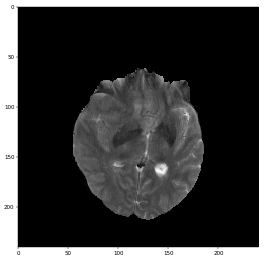

In [17]:
#Bias correction is possible, but would take a LONG time. (time per slice ~ 1 second)
sitk_show(bias_correct(s_vol[:,:,67]))

In [55]:
#This grabs all patient folders.
patients = []
for path, dirs, files in os.walk('./brats_2015/'):
    if 'Testing' not in path: #No Masks
        for d in dirs:
            if 'pat' in d and not 'brats_2013' in d: #Ignore data from the wrong year.
                patients.append(os.path.join(path,d))



'''
This will be in a for loop.
'''

xs, y = grab_mhas(patients['INSERT SOMETHING HERE'])

#Grab patient ID from filename
pid = xs[0].name.split('.')[-2]

#Run slicewise normalization on each volume
vols_list = [slice_norm(load_vol(x)) for x in xs]

#Also load the mask volume
mask_vol = load_vol(y[0])

#Stick everything together
vols_list.append(mask_vol)
vols = np.array(vols_list)

#Grab the number of slices.
n_slices = vols.shape[1]


#Modify output files here:
for s in range(n_slices):
    a,b,c,d,m = vols[:,s,:,:]
    tensor = torch.from_numpy(np.stack([a,b,c,d], axis=2))
    #Specifically this one...
    torch.save(tensor,f'./test_dump/{pid}_{s}.pt')
    mask_tensor = torch.from_numpy(m)
    #And this one.
    torch.save(mask_tensor,f'./test_dump/mask_{pid}_{s}.pt')

torch.Size([240, 240, 4])

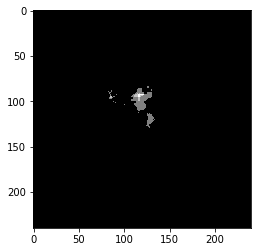

In [135]:
plt.imshow(vols[4,70,:,:])

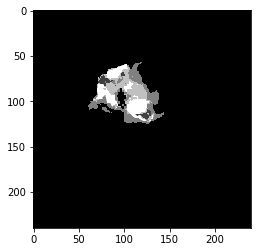

In [57]:
plt.imshow(torch.load('./test_dump/mask_35588_80.pt'))

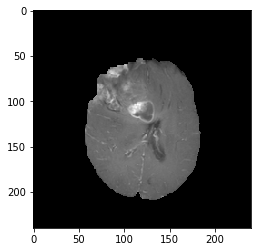

In [58]:
plt.imshow(torch.load('./test_dump/35588_80.pt')[:,:,2])